# Install and Imports

In [1]:
# %pip install autoray
# %pip install opt_einsum

# %pip install --no-deps -U git+https://github.com/jcmgray/quimb.git@08ab4805df6be023e1027503b8c0915e1bf50b34
# %pip install -U git+https://github.com/jcmgray/cotengra.git
# %pip install kahypar

In [2]:
# just set up some misc notebook plotting stuff

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [3]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import quimb.tensor as qtn
import cotengra as ctg
import quimb as qu
import numpy as np
import time, random

# Main

### Utils

In [4]:

import pyzx as zx
import importlib
importlib.reload(zx)
zx.settings.drawing_backend = 'd3'
def show(g):
  return zx.draw_matplotlib(g,labels=True,h_edge_draw='box')
def show_d3(g):
  return zx.draw_d3(g)

In [5]:
def compute_stats(g):
    g1 = g.copy()
    from pyzx.hsimplify import to_hypergraph_form
    to_hypergraph_form(g1)
    count_hbox = 0
    count_z = 0
    count = 0
    one_arity = 0
    two_arity = 0
    three_arity = 0
    phase_hbox =0
    degree=0
    hbox_degree=0
    hbox_tensor_degree = 0
    for v in g1.vertices():
        count_hbox+= g1.type(v)==3
        degree += len(g1.neighbors(v))
        hbox_degree += len(g1.neighbors(v)) if g1.type(v)==3 else 0
        if g1.type(v)==3:
            phase_hbox += ((len(g1.neighbors(v))!=1) and (g1.phase(v) != 1))
            one_arity+= len(g1.neighbors(v))==1
            two_arity+= len(g1.neighbors(v))==2
            three_arity+= len(g1.neighbors(v))==3
            hbox_tensor_degree += sum([(len(g1.neighbors(v_z))-1) for v_z in g1.neighbors(v)])
        count_z+=g1.type(v)==1
        count+=1
    print(f'H_box/Total = {count_hbox/count}')
    print(f'Z/Total = {count_z/count}')
    print(f'Multiarity Hbox/Total = {(two_arity+three_arity)/count}')
    print(f'Multiarity phase Hbox/Total = {phase_hbox/count_hbox}')
    print(f'total num of Z = {count_z}')
    print(f'total num of Hbox = {count_hbox}')
    print(f'One arity Hboxes = {one_arity}')
    print(f'Two arity Hboxes = {two_arity}')
    print(f'Three arity Hboxes = {three_arity}')
    print(f'Average degree = {degree/count}')
    print(f'Average Hbox degree = {hbox_degree/count_hbox}')
    print(f'Average Hbox tensor degree = {hbox_tensor_degree/count_hbox}')

In [6]:
ctg.list_hyper_functions()

['betweenness',
 'flowcutter',
 'greedy',
 'greedy-compressed',
 'greedy-span',
 'kahypar',
 'kahypar-agglom',
 'kahypar-balanced',
 'labelprop',
 'labels',
 'labels-agglom',
 'quickbb',
 'spinglass',
 'walktrap']

In [7]:
def compute_contraction_costs(tn, progbar=True):
    print(f'#Tensors={tn.num_tensors}, #Indices={tn.num_indices}')
    print("-"*10+"-> Applying quimb's full_simplify ...")
    tn.full_simplify_('ADCRSL',output_inds=())
    print(f'#Tensors={tn.num_tensors}, #Indices={tn.num_indices}')
    opt = ctg.HyperOptimizer(
        methods=['greedy',
                'kahypar'],
        max_repeats=256,
        progbar=progbar,
        minimize='flops',
        score_compression=0.5,  # deliberately make the optimizer try many methods 
    )
    print("-"*10+"-> Finding contraction tree...")
    info = tn.contract(all, optimize=opt,output_inds=(), get='path-info')
    tree = opt.get_tree()
    print(f' Contraction cost = {tree.contraction_cost():e} \n Memory cost = {tree.contraction_width():e}')

### Quimb Tensor Contraction

In [ ]:
file = '../circuits/qasm/barenco_tof_10.qasm'

### PyZX Tensor Contraction

In [19]:
circ1 = zx.Circuit.from_qasm_file(file)
g1 = circ1.to_graph(zh=True)
qubits = circ1.qubits
g1.apply_effect("0"*qubits)
g1.apply_state("0"*qubits)

In [15]:
compute_stats(g1)

H_box/Total = 0.5827713726343268
Z/Total = 0.4172286273656733
Multiarity Hbox/Total = 0.3583859038503372
Multiarity phase Hbox/Total = 0.0
total num of Z = 7672
total num of Hbox = 10716
One arity Hboxes = 4126
Two arity Hboxes = 6590
Three arity Hboxes = 0
Average degree = 2.13454426800087
Average Hbox degree = 1.6149682717431877
Average Hbox tensor degree = 3.1020903322135127


In [16]:
from pyzx.simplify import greedy_simp, greedy_simp_neighbors
greedy_simp_neighbors(g1, quiet=False)

spider_simp: 1114. 715. 241. 34.  4 iterations
id_simp: 659.  1 iterations
spider_simp: 223. 217. 4.  3 iterations
id_simp: 13.  1 iterations
spider_simp: 13.  1 iterations


2

In [17]:
compute_stats(g1)

H_box/Total = 0.6782483552631579
Z/Total = 0.3217516447368421
Multiarity Hbox/Total = 0.40337171052631576
Multiarity phase Hbox/Total = 0.0
total num of Z = 3130
total num of Hbox = 6598
One arity Hboxes = 2674
Two arity Hboxes = 3924
Three arity Hboxes = 0
Average degree = 2.1632401315789473
Average Hbox degree = 1.5947256744468021
Average Hbox tensor degree = 3.989693846620188


In [ ]:
from pyzx.simplify import simulated_annealing_simp
simulated_annealing_simp(g1,iterations=1500,quiet=False)

In [12]:
compute_stats(g1)

H_box/Total = 0.6751669702489375
Z/Total = 0.32483302975106254
Multiarity Hbox/Total = 0.3995142683667274
Multiarity phase Hbox/Total = 0.0
total num of Z = 1605
total num of Hbox = 3336
One arity Hboxes = 1362
Two arity Hboxes = 1974
Three arity Hboxes = 0
Average degree = 2.1493624772313296
Average Hbox degree = 1.591726618705036
Average Hbox tensor degree = 3.9382494004796165


In [47]:
compute_stats(g1)

H_box/Total = 0.6747383541965934
Z/Total = 0.32526164580340655
Multiarity Hbox/Total = 0.4038579930227786
Multiarity phase Hbox/Total = 0.0
total num of Z = 1585
total num of Hbox = 3288
One arity Hboxes = 1320
Two arity Hboxes = 1968
Three arity Hboxes = 0
Average degree = 2.157192694438744
Average Hbox degree = 1.5985401459854014
Average Hbox tensor degree = 4.147810218978102


In [15]:
compute_stats(g1)

H_box/Total = 0.674404272801972
Z/Total = 0.32559572719802793
Multiarity Hbox/Total = 0.40427280197206245
Multiarity phase Hbox/Total = 0.0
total num of Z = 1585
total num of Hbox = 3283
One arity Hboxes = 1315
Two arity Hboxes = 1968
Three arity Hboxes = 0
Average degree = 2.157354149548069
Average Hbox degree = 1.0786770747740344


In [14]:
tn1 = zx.to_quimb_tensor(g1)
compute_contraction_costs(tn1, progbar=True)

#Tensors=6598, #Indices=3130
-----------> Applying quimb's full_simplify ...
#Tensors=1065, #Indices=774
-----------> Finding contraction tree...


log2[SIZE]: 27.00 log10[FLOPs]: 10.47: 100%|██████████| 256/256 [16:38<00:00,  3.90s/it]  


 Contraction cost = 1.483874e+10 
 Memory cost = 2.700000e+01


In [ ]:
zx.reduce_scalar(g1, quiet=False)

id_simp: 436.  1 iterations
spider_simp: 578. 295. 109. 12.  4 iterations
id_simp: 9.  1 iterations
spider_simp: 9.  1 iterations


2

In [14]:
g2 = g1.copy()

In [12]:
zx.full_reduce(g1, quiet=False)

spider_simp: 1114. 715. 241. 34.  4 iterations
id_simp: 659.  1 iterations
spider_simp: 223. 217. 4.  3 iterations
lcomp_simp: 1557. 158. 10.  3 iterations
id_simp: 6.  1 iterations
spider_simp: 6.  1 iterations
pivot_gadget_simp: 528. 270. 83. 1.  4 iterations
id_simp: 144.  1 iterations
spider_simp: 123. 21.  2 iterations
gadget_simp: 346.  1 iterations
id_simp: 1.  1 iterations
spider_simp: 1.  1 iterations


In [13]:
compute_stats(g1)

H_box/Total = 0.7101335428122545
Z/Total = 0.2898664571877455
Multiarity Hbox/Total = 0.50471327572663
Multiarity phase Hbox/Total = 0.0
total num of Z = 2214
total num of Hbox = 5424
One arity Hboxes = 1569
Two arity Hboxes = 3855
Three arity Hboxes = 0
Average degree = 2.429693637077769
Average Hbox degree = 1.7107300884955752
Average Hbox tensor degree = 7.626843657817109


In [ ]:
show_d3(g1)

In [19]:
compute_stats(g1)

H_box/Total = 0.7083659108678655
Z/Total = 0.29163408913213446
Multiarity Hbox/Total = 0.5019546520719312
Multiarity phase Hbox/Total = 0.0
total num of Z = 1119
total num of Hbox = 2718
One arity Hboxes = 792
Two arity Hboxes = 1926
Three arity Hboxes = 0
Average degree = 2.4206411258795932
Average Hbox degree = 1.2103205629397966


In [18]:
tn1 = zx.to_quimb_tensor(g1)
compute_contraction_costs(tn1, progbar=True)

#Tensors=2718, #Indices=1119
-----------> Applying quimb's full_simplify ...


KeyboardInterrupt: 

In [52]:
zx.full_reduce(g2, quiet=False)

spider_simp: 602. 368. 121. 12.  4 iterations
id_simp: 336.  1 iterations
spider_simp: 116. 109. 2.  3 iterations
lcomp_simp: 821. 93. 8.  3 iterations
id_simp: 1.  1 iterations
spider_simp: 1.  1 iterations
pivot_gadget_simp: 278. 134. 43. 1.  4 iterations
id_simp: 68.  1 iterations
spider_simp: 63. 5.  2 iterations
gadget_simp: 179.  1 iterations


In [53]:
compute_stats(g2)

H_box/Total = 0.7047493403693932
Z/Total = 0.29525065963060687
Multiarity Hbox/Total = 0.495778364116095
Multiarity phase Hbox/Total = 0.0
total num of Z = 1119
total num of Hbox = 2671
One arity Hboxes = 792
Two arity Hboxes = 1879
Three arity Hboxes = 0
Average degree = 2.401055408970976
Average Hbox degree = 1.703481842006739
Average Hbox tensor degree = 7.241482590789967


In [ ]:
show_d3(g1)

In [ ]:
tn1 = zx.to_quimb_tensor(g1)
compute_contraction_costs(tn1)

#Tensors=2671, #Indices=1119
-----------> Applying quimb's full_simplify ...
#Tensors=309, #Indices=201
-----------> Finding contraction tree...


log2[SIZE]: 12.00 log10[FLOPs]: 5.85: 100%|██████████| 256/256 [00:58<00:00,  4.40it/s]

 Contraction cost = 3.553880e+05 
 Memory cost = 1.200000e+01


In [18]:
from pyzx.hsimplify import zh_simp, new_simp
new_simp(g1)

copy_simp: 40.  1 iterations
spider_simp: 40.  1 iterations
pivot_gadget_simp: 279. 114.  2 iterations
id_simp: 121.  1 iterations
spider_simp: 121.  1 iterations
hpivot: 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

5

In [19]:
compute_stats(g1)

H_box/Total = 0.705545950259343
Z/Total = 0.294454049740657
Multiarity Hbox/Total = 0.411091900518686
Multiarity phase Hbox/Total = 0.04052780395852969
total num of Z = 2214
total num of Hbox = 5305
One arity Hboxes = 2214
Two arity Hboxes = 3091
Three arity Hboxes = 0
Average degree = 2.233275701556058
Average Hbox degree = 1.5826578699340246
Average Hbox tensor degree = 4.720829406220546


In [20]:
tn1 = zx.to_quimb_tensor(g1)
compute_contraction_costs(tn1)

#Tensors=5305, #Indices=2214
-----------> Applying quimb's full_simplify ...
#Tensors=1006, #Indices=741
-----------> Finding contraction tree...


log2[SIZE]: 26.00 log10[FLOPs]: 10.45: 100%|██████████| 256/256 [08:13<00:00,  1.93s/it]


 Contraction cost = 1.402505e+10 
 Memory cost = 2.600000e+01


In [54]:
new_simp(g2)

hpivot: 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.  327 iterat

1

In [55]:
compute_stats(g2)

H_box/Total = 0.7609254498714653
Z/Total = 0.2390745501285347
Multiarity Hbox/Total = 0.5691516709511568
Multiarity phase Hbox/Total = 0.3668918918918919
total num of Z = 465
total num of Hbox = 1480
One arity Hboxes = 373
Two arity Hboxes = 999
Three arity Hboxes = 108
Average degree = 2.7712082262210798
Average Hbox degree = 1.820945945945946
Average Hbox tensor degree = 10.154054054054054


In [58]:
tn2 = zx.to_quimb_tensor(g2)
compute_contraction_costs(tn2)

#Tensors=1480, #Indices=465
-----------> Applying quimb's full_simplify ...
#Tensors=303, #Indices=186
-----------> Finding contraction tree...


log2[SIZE]: 12.00 log10[FLOPs]: 5.77: 100%|██████████| 256/256 [01:20<00:00,  3.17it/s]

 Contraction cost = 2.920880e+05 
 Memory cost = 1.200000e+01


In [ ]:
show_d3(g1)

In [25]:
tn1 = zx.to_quimb_tensor(g2)
compute_contraction_costs(tn1)

#Tensors=2385, #Indices=919
-----------> Applying quimb's full_simplify ...
#Tensors=327, #Indices=266
-----------> Finding contraction tree...


log2[SIZE]: 12.00 log10[FLOPs]: 5.67: 100%|██████████| 256/256 [01:10<00:00,  3.65it/s]

 Contraction cost = 2.337080e+05 
 Memory cost = 1.200000e+01


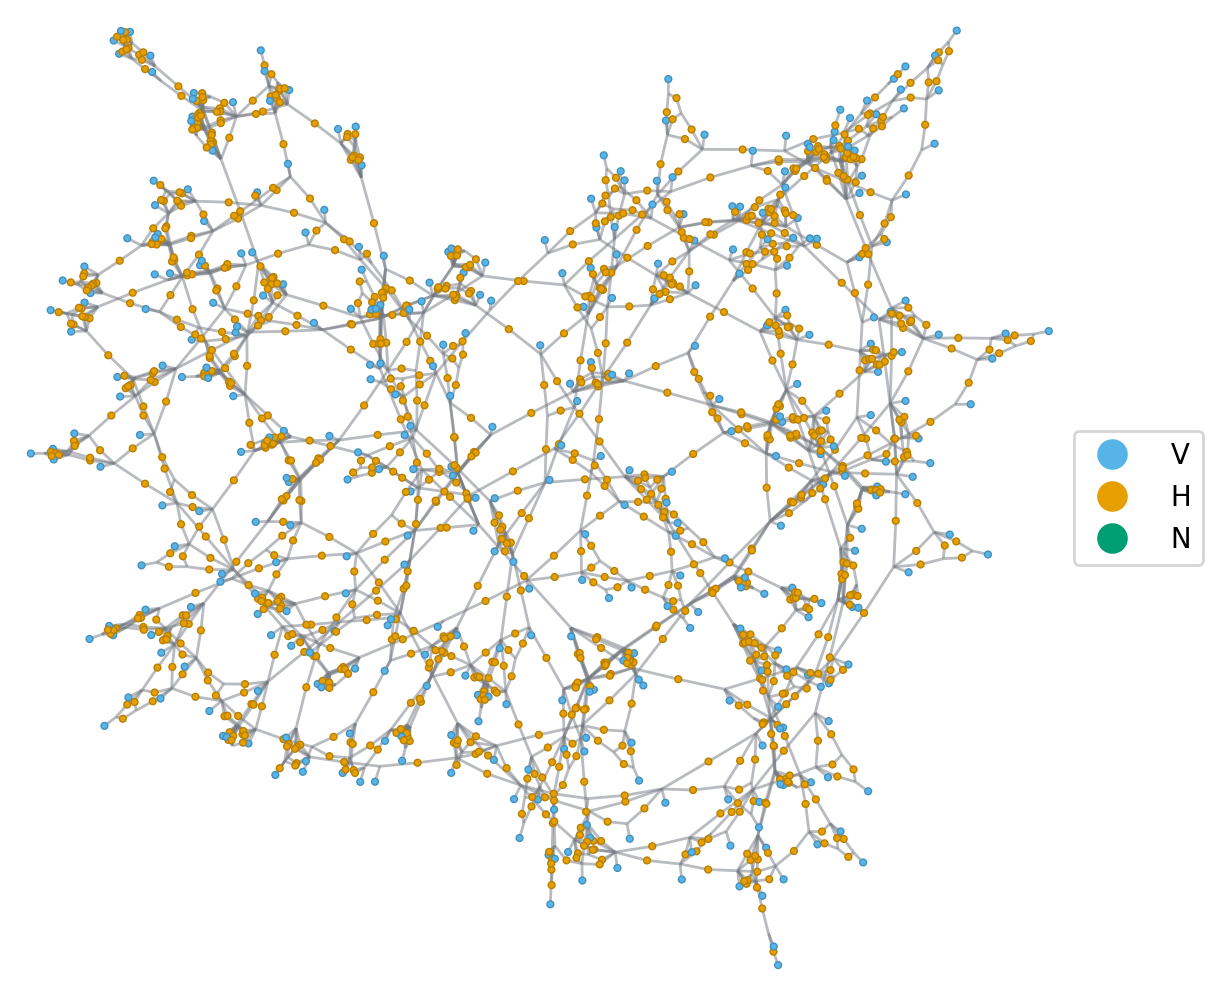

In [ ]:
tn1 = zx.to_quimb_tensor(g1)
tn1.draw(color=['V','H', 'N'])